In [ ]:
!pip install scanpy anndata pandas scikit-learn matplotlib seaborn loompy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 29.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.6 MB/s eta 0:00:00
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52019 sha256=df17a255bd7e45336b614733fb4f3b397bf41f22bbda6dd424397538946a6567
  Stored in directory: /root/.cache/pip/wheels/2c/22/1f/792a4621bb631e538bf1c21feae9bbaa6b19fd6d6ab382d1fd
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=29902f

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scanpy as sc

# Load your data
h5ad_path = "/content/drive/MyDrive/Colab Notebooks/Aggregated_filtered_normalised_count.h5ad"
adata = sc.read_h5ad(h5ad_path)

In [ ]:
print(adata.X[:5, :5].toarray())

[[170.99864   92.98001  151.9372     0.         0.      ]
 [  0.         0.        50.645733   0.         0.      ]
 [  0.        92.98001  101.291466   0.         0.      ]
 [  0.         0.        50.645733   0.         0.      ]
 [  0.         0.         0.         0.         0.      ]]


In [ ]:
print(adata.var.head())

Empty DataFrame
Columns: []
Index: [SAMEA6739629-AAACCTGAGATGTAAC, SAMEA6739629-AAACCTGCAATCCAAC, SAMEA6739629-AAACCTGCACCGAAAG, SAMEA6739629-AAACCTGCACGTAAGG, SAMEA6739629-AAACCTGCACGTCAGC]


In [ ]:
print(adata.obs.head())

Empty DataFrame
Columns: []
Index: [ENSG00000000003, ENSG00000000005, ENSG00000000419, ENSG00000000457, ENSG00000000460]


In [ ]:
# Correct summing and normalization
gene_sums = adata.X.sum(axis=0)  # Sum across cells for each gene
gene_cell_counts = (adata.X > 0).sum(axis=0)  # Count cells where each gene is expressed
normalized_gene_expression = gene_sums / gene_cell_counts  # Normalize gene expression

In [ ]:
import pandas as pd
import scipy.sparse as sp

# Load the gene-pathway mapping and drop rows with NaN in 'Ensembl Gene ID'
gene_pathway_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/gene_pathway_single.csv")
gene_pathway_df = gene_pathway_df.dropna(subset=['Ensembl Gene ID'])

gene_pathway_df = gene_pathway_df.copy()
# Ensure the 'Ensembl Gene ID' column is of type string, if necessary
gene_pathway_df['Ensembl Gene ID'] = gene_pathway_df['Ensembl Gene ID'].astype(str)

# Debugging: Check if any gene IDs are empty or not matching
# print("Number of gene IDs in gene_pathway_df:", gene_pathway_df['Ensembl Gene ID'].nunique())
# print("Sample gene IDs from gene_pathway_df:", gene_pathway_df['Ensembl Gene ID'].dropna().unique()[:5])

# Initialize an empty dataframe to hold the PAS
pathway_activity_scores = pd.DataFrame(0, index=adata.obs_names, columns=gene_pathway_df['Pathway ID'].unique())

# Loop over each pathway to calculate scores
for pathway_id in pathway_activity_scores.columns:
    # Get the genes for this pathway
    pathway_genes = gene_pathway_df[gene_pathway_df['Pathway ID'] == pathway_id]['Ensembl Gene ID']

    # Debugging: Check if pathway_genes is not empty
    # print(f"Pathway ID: {pathway_id}, Genes in pathway: {pathway_genes.values}")

    # Find the indices of these genes in `adata.var_names`
    gene_indices = [np.where(adata.var_names == gene_id)[0][0] for gene_id in pathway_genes if gene_id in adata.var_names and np.where(adata.var_names == gene_id)[0].size > 0]

    # Debugging: Check the gene indices
    # print(f"Gene indices for pathway {pathway_id}: {gene_indices}")

    # If the pathway has no genes, skip to the next pathway
    if not gene_indices:
        print(f"No genes found for pathway {pathway_id}")
        continue

    # Extract the expression data for these genes
    if sp.issparse(adata.X):
        pathway_data = adata.X[:, gene_indices].toarray()
    else:
        pathway_data = adata.X[:, gene_indices]

    # Debugging: Check the summed data before normalization
    pathway_sum = pathway_data.sum(axis=1)
    # print(f"Pathway sum before normalization for {pathway_id}: {pathway_sum}")

    # Sum and normalize the data across the genes to get total pathway activity
    normalized_scores = pathway_sum / len(gene_indices)
    pathway_activity_scores[pathway_id] = normalized_scores

    # Debugging: Check for non-zero scores
    non_zero_scores = normalized_scores[np.nonzero(normalized_scores)]
    # print(f"Non-zero scores for pathway {pathway_id}: {non_zero_scores}")

# Check if `pathway_activity_scores` DataFrame contains non-zero values
# print("Non-zero scores in pathway_activity_scores:")
# print(pathway_activity_scores[pathway_activity_scores > 0].dropna(how='all', axis=1))

print(pathway_activity_scores.head())


<ipython-input-25-38734af27944>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_pathway_df['Ensembl Gene ID'] = gene_pathway_df['Ensembl Gene ID'].astype(str)


                                 hsa00010   hsa00020   hsa00030   hsa00040  \
SAMEA6739629-AAACCTGAGATGTAAC  106.184641  18.321283  56.016795  16.624868   
SAMEA6739629-AAACCTGCAATCCAAC  148.468080  26.565717  57.711730  20.662224   
SAMEA6739629-AAACCTGCACCGAAAG  149.153290  52.454509  42.786913  14.068259   
SAMEA6739629-AAACCTGCACGTAAGG   92.798149  39.515695  38.153084   0.000000   
SAMEA6739629-AAACCTGCACGTCAGC   90.654400  60.495404  39.824560  21.387264   

                                hsa00051   hsa00052   hsa00053   hsa00500  \
SAMEA6739629-AAACCTGAGATGTAAC  25.146859   2.758043  28.499773   4.749962   
SAMEA6739629-AAACCTGCAATCCAAC  60.163535  35.992262  21.695336  20.662224   
SAMEA6739629-AAACCTGCACCGAAAG  37.239510  21.238533  25.478129  16.881911   
SAMEA6739629-AAACCTGCACGTAAGG  13.016935   7.138319  44.257578   6.146886   
SAMEA6739629-AAACCTGCACGTCAGC  20.380804  19.869458   5.132943  29.942169   

                                hsa00520    hsa00620  ...    hsa0541

In [ ]:
pathway_activity_scores.to_csv("/content/drive/MyDrive/Colab Notebooks/pathway_activity_scores.csv")

In [ ]:
import pandas as pd

# Assuming `pathway_activity_scores` is a pandas DataFrame with cells as index and pathways as columns.

# Global Expression Level Queries
def query_global_expression(dataframe, threshold, query_type='high'):
    """
    Query cells with high or low total pathway activity scores.

    :param dataframe: DataFrame containing pathway activity scores.
    :param threshold: Threshold value for total pathway activity score.
    :param query_type: 'high' for high expression, 'low' for low expression.
    :return: DataFrame of cells that meet the query condition.
    """
    total_scores = dataframe.sum(axis=1)
    if query_type == 'high':
        return dataframe.loc[total_scores >= threshold]
    elif query_type == 'low':
        return dataframe.loc[total_scores <= threshold]

# Pathway-Specific Expression Queries
def query_pathway_specific(dataframe, pathway_id, threshold, query_type='above'):
    """
    Query cells based on the expression level of a specific pathway.

    :param dataframe: DataFrame containing pathway activity scores.
    :param pathway_id: Specific pathway ID to query.
    :param threshold: Threshold value for pathway activity score.
    :param query_type: 'above' for scores above the threshold, 'below' for scores below.
    :return: DataFrame of cells that meet the query condition.
    """
    if query_type == 'above':
        return dataframe.loc[dataframe[pathway_id] >= threshold]
    elif query_type == 'below':
        return dataframe.loc[dataframe[pathway_id] <= threshold]

# Co-Expression Queries
def coexpression_query(dataframe, pathways_list, threshold, mode='above'):
    """
    Enhanced query for co-expression, where pathways must be simultaneously above or below a threshold.

    :param dataframe: DataFrame containing pathway activity scores.
    :param pathways_list: List of pathways to query.
    :param threshold: Numerical threshold for pathway activity.
    :param mode: 'above' for activity above the threshold, 'below' for below the threshold.
    :return: DataFrame of cells that meet the co-expression criteria.
    """
    if mode == 'above':
        mask = (dataframe[pathways_list] > threshold).all(axis=1)
    else:
        mask = (dataframe[pathways_list] < threshold).all(axis=1)
    return dataframe[mask]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the pathway activity scores DataFrame
pathway_activity_scores = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/pathway_activity_scores.csv", index_col=0)


In [ ]:
# Example of running a global expression level query for cells with high total pathway activity
high_activity_cells = query_global_expression(pathway_activity_scores, threshold=33000, query_type='high')
print("High Activity Cells:\n", high_activity_cells)


High Activity Cells:
                                  hsa00010   hsa00020    hsa00030   hsa00040  \
SAMEA6739629-GCAGTTAAGAAGGACA   99.248483  20.443209   24.672839   0.000000   
SAMEA6739629-TAGACCACAAAGAATC  117.462810  65.257116   80.108736  13.051423   
SAMEA6739630-CATCCACCAAGAGTCG   99.561926  31.494079   30.408076  48.990789   
SAMEA6739630-CTGATCCAGAAGGCCT  101.258493  32.030747  123.704959   0.000000   
SAMEA6739632-ATAAGAGCATCACGTA  127.723975  58.149366   89.320345  12.334714   
...                                   ...        ...         ...        ...   
SAMEA6739639-TCGGGACGTCGATTGT   82.643510  14.999700   55.033384  27.999440   
SAMEA6739639-TCTCATATCGCGCCAA   29.961052   0.000000    0.000000   0.000000   
SAMEA6739639-TGACTTTGTCCAACTA   61.307690  73.532736   54.613172  17.597578   
SAMEA6739639-TTAGGACAGGTTCCTA  108.168254  40.576731   76.178535  17.533155   
SAMEA6739639-TTGACTTGTCTCTTAT  114.066705  57.731720   76.643834  44.902448   

                             

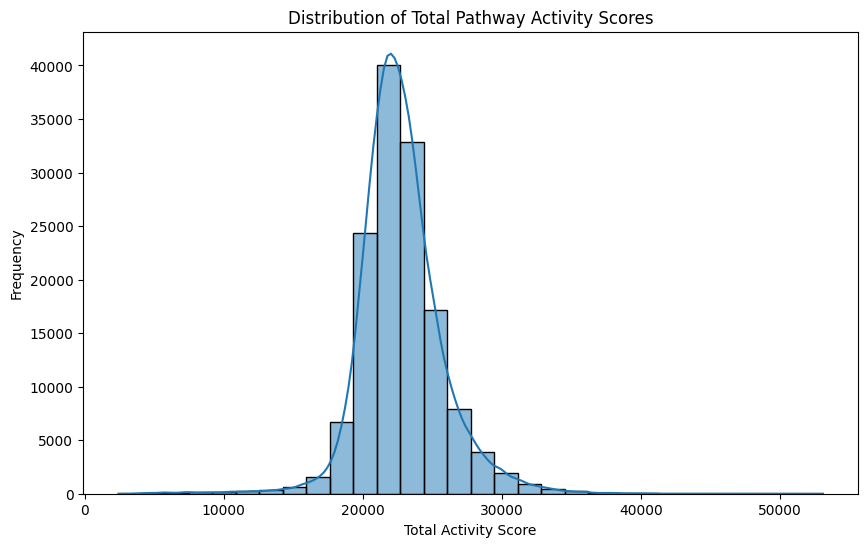

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate total pathway activity scores for each cell
total_scores = pathway_activity_scores.sum(axis=1)

# Plotting the distribution of total scores
plt.figure(figsize=(10, 6))
sns.histplot(total_scores, bins=30, kde=True)
plt.title('Distribution of Total Pathway Activity Scores')
plt.xlabel('Total Activity Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Define thresholds for high and low activity
mean_score = total_scores.mean()
std_score = total_scores.std()
high_threshold = mean_score + std_score  # One standard deviation above the mean
low_threshold = mean_score - std_score   # One standard deviation below the mean

# Query for high activity cells
high_activity_cells = pathway_activity_scores[total_scores >= high_threshold]
print("High Activity Cells:\n", high_activity_cells)

# Query for low activity cells
low_activity_cells = pathway_activity_scores[total_scores <= low_threshold]
print("Low Activity Cells:\n", low_activity_cells)

High Activity Cells:
                                  hsa00010   hsa00020   hsa00030   hsa00040  \
SAMEA6739629-AAATGCCAGGTGCTTT   71.487900  30.151359  65.501227  17.588292   
SAMEA6739629-AACTCCCCACAGGAGT  151.712331  72.853254  27.354862   9.443940   
SAMEA6739629-AACTGGTAGCTGAAAT   72.653302  48.262550  46.598324  37.537539   
SAMEA6739629-AAGACCTCACGGTAAG   77.229657  43.354273  62.788948  29.973325   
SAMEA6739629-AAGTCTGGTTCAGGCC   97.022563  34.373708  26.550726   8.020532   
...                                   ...        ...        ...        ...   
SAMEA6739639-TTTATGCGTCTGCAAT   74.290126  46.489005  44.885936  16.688361   
SAMEA6739639-TTTCCTCCAGATTGCT   95.123905  39.187257  42.565469  19.049361   
SAMEA6739639-TTTGCGCTCGGTCTAA   59.537648  69.055571  48.490433  34.179015   
SAMEA6739639-TTTGTCACAGGGTACA   88.731862  65.492564  83.354173  15.050059   
SAMEA6739639-TTTGTCATCACTATTC  151.230220  83.716727  66.772562  33.972003   

                                hsa00051 

In [ ]:
# Example of querying for cells with specific pathway expression above a threshold
specific_pathway_cells = query_pathway_specific(pathway_activity_scores, pathway_id='hsa00010', threshold=220, query_type='above')
print("Specific Pathway High Expression Cells:\n", specific_pathway_cells)

Specific Pathway High Expression Cells:
                                  hsa00010    hsa00020    hsa00030   hsa00040  \
SAMEA6739629-ACTGATGCAACTGGCC  264.676659   59.241706   67.412976  46.076883   
SAMEA6739629-AGCTCCTAGCACCGTC  263.278769   61.969994   50.385766  17.757483   
SAMEA6739629-ATCATGGGTACGAAAT  260.863006   41.664770   60.342080  38.297920   
SAMEA6739629-ATGTGTGCAAAGGAAG  251.501235   59.666647   93.222103  21.938040   
SAMEA6739629-CACATAGAGGAATGGA  230.342732   35.889246   54.143258  27.913857   
...                                   ...         ...         ...        ...   
SAMEA6739639-TACTCGCAGGACAGAA  247.641524   84.611727   83.265121  12.655600   
SAMEA6739639-TCGTACCAGTCCATAC  246.536433  105.405945  106.196098  81.982401   
SAMEA6739639-TGAAAGATCACTTCAT  236.505853   80.081601   66.129091  11.473680   
SAMEA6739639-TGAGAGGAGTTCCACA  229.233685   99.853547  249.060008  25.887956   
SAMEA6739639-TGCCCTAGTCCAGTGC  428.107601  128.008190   93.530682  32.290354   

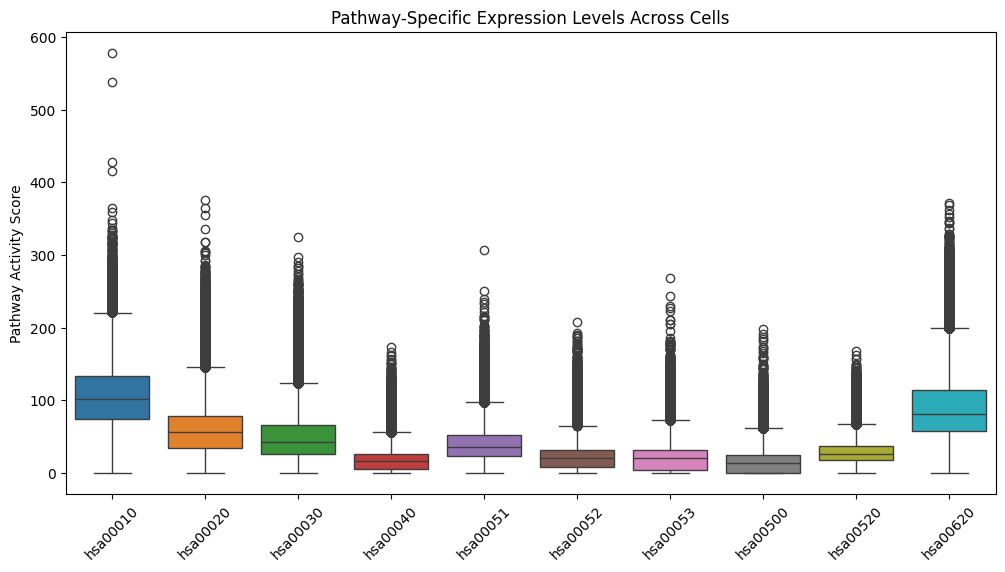

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a subset of pathways to visualize
pathways_to_plot = pathway_activity_scores.columns[:10]  # Adjust the slice as needed

# Plotting
plt.figure(figsize=(12, 6))
sns.boxplot(data=pathway_activity_scores[pathways_to_plot])
plt.xticks(rotation=45)
plt.title('Pathway-Specific Expression Levels Across Cells')
plt.ylabel('Pathway Activity Score')
plt.show()


In [ ]:
# Example for a specific pathway
pathway_id = 'hsa00010'  # Example pathway ID

# Ranking cells by their expression level in the pathway
ranked_cells = pathway_activity_scores[[pathway_id]].sort_values(by=pathway_id, ascending=False)
print("Ranked cells based on pathway expression (Top 10):\n", ranked_cells.head(10))


Ranked cells based on pathway expression (Top 10):
                                  hsa00010
SAMEA6739639-AGCCCTAGTCCAGTGC  578.127734
SAMEA6739638-TTTGTCAAGATCGGGT  537.634450
SAMEA6739639-TGCCCTAGTCCAGTGC  428.107601
SAMEA6739635-AACCAATGTAAAGTCA  415.696713
SAMEA6739638-AGCAGCCTCGCTAGCG  364.389570
SAMEA6739638-AAGATCAAGCTGCAAG  359.946505
SAMEA6739634-AAGACCACATTGAGCT  348.504496
SAMEA6739638-GAGGTGATCTTAGAGC  344.353132
SAMEA6739639-TAAGCGTTCGTCGTTC  337.249350
SAMEA6739638-ATCGAAACAATTCCTT  335.180170


In [ ]:
"""# Example of a co-expression query across multiple pathways
pathways_list = ['hsa00010', 'hsa00020', 'hsa00030']
co_expressed_cells = coexpression_query(pathway_activity_scores, pathways_list, threshold=80)
print("Co-Expressed Cells:\n", co_expressed_cells)"""

Co-Expressed Cells:
                                  hsa00010    hsa00020    hsa00030   hsa00040  \
SAMEA6739629-ACATCAGCAATGTTGC  157.687639   92.730131   97.178467  35.758743   
SAMEA6739629-ACGATACAGAATCTCC  139.865172   93.429490   95.219327  26.913845   
SAMEA6739629-ACGGAGATCAGTACGT  131.779914  114.881250   82.080674  25.018584   
SAMEA6739629-AGTGGGAAGGAATGGA   92.770424   93.700454   93.948996   5.606010   
SAMEA6739629-CAACTAGAGAGGTACC  211.595356   92.733899  103.136609  21.911807   
...                                   ...         ...         ...        ...   
SAMEA6739639-TGCCCTAGTCCAGTGC  428.107601  128.008190   93.530682  32.290354   
SAMEA6739639-TGCGTGGCAAGGTGTG  132.279970   80.801557  107.271033  15.711414   
SAMEA6739639-TGGTTAGCAAAGAATC   88.684618   93.917560  107.166119  39.843813   
SAMEA6739639-TTCGAAGAGATCTGCT  166.398359   85.686864   91.005359  19.993602   
SAMEA6739639-TTGGCAACAGATTGCT  119.782935   80.723282  144.745199  49.330894   

                  

In [ ]:
# Define the list of pathway IDs for the query
pathways_list = ['hsa00010', 'hsa00020', 'hsa00030']
# Example usage:
co_expressed_cells_above = coexpression_query(pathway_activity_scores, pathways_list, 80, 'above')
co_expressed_cells_below = coexpression_query(pathway_activity_scores, pathways_list, 20, 'below')

print("Co-Expressed Cells Above 80:\n", co_expressed_cells_above)
print("Co-Expressed Cells below 20:\n", co_expressed_cells_below)

Co-Expressed Cells Above 80:
                                  hsa00010    hsa00020    hsa00030   hsa00040  \
SAMEA6739629-ACATCAGCAATGTTGC  157.687639   92.730131   97.178467  35.758743   
SAMEA6739629-ACGATACAGAATCTCC  139.865172   93.429490   95.219327  26.913845   
SAMEA6739629-ACGGAGATCAGTACGT  131.779914  114.881250   82.080674  25.018584   
SAMEA6739629-AGTGGGAAGGAATGGA   92.770424   93.700454   93.948996   5.606010   
SAMEA6739629-CAACTAGAGAGGTACC  211.595356   92.733899  103.136609  21.911807   
...                                   ...         ...         ...        ...   
SAMEA6739639-TGCCCTAGTCCAGTGC  428.107601  128.008190   93.530682  32.290354   
SAMEA6739639-TGCGTGGCAAGGTGTG  132.279970   80.801557  107.271033  15.711414   
SAMEA6739639-TGGTTAGCAAAGAATC   88.684618   93.917560  107.166119  39.843813   
SAMEA6739639-TTCGAAGAGATCTGCT  166.398359   85.686864   91.005359  19.993602   
SAMEA6739639-TTGGCAACAGATTGCT  119.782935   80.723282  144.745199  49.330894   

         

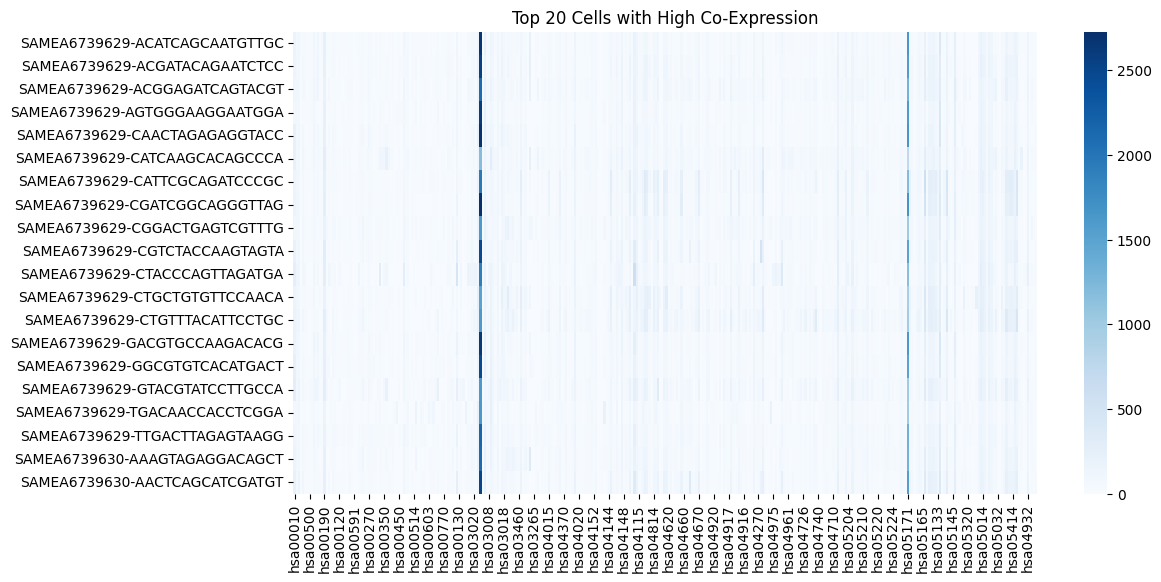

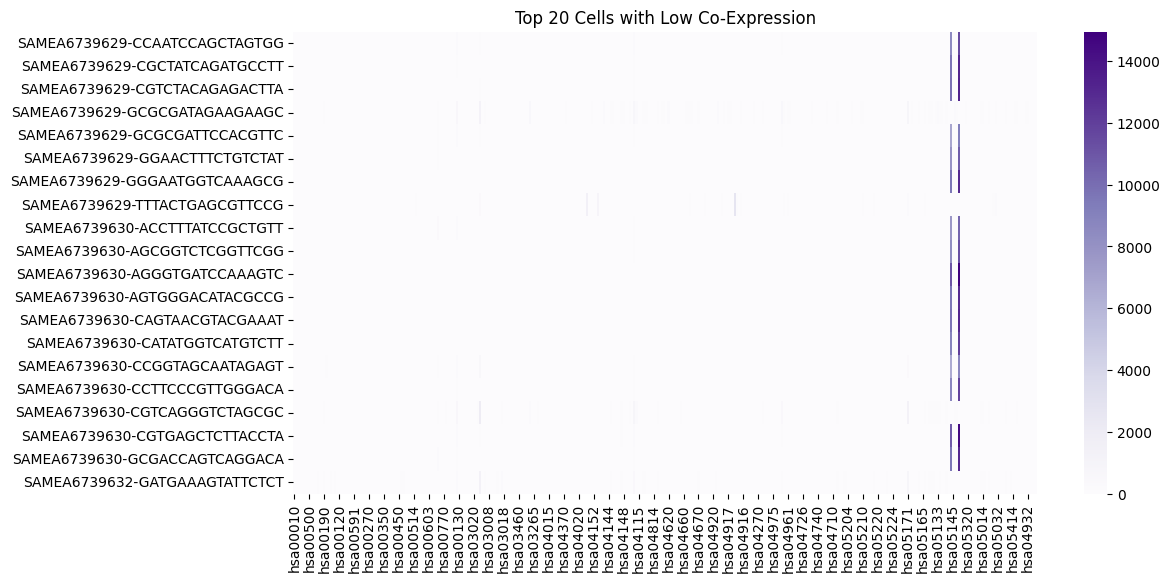

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization
# Displaying only the top 20 cells for each condition
plt.figure(figsize=(12, 6))
sns.heatmap(co_expressed_cells_above.head(20), annot=False, cmap='Blues')
plt.title('Top 20 Cells with High Co-Expression')
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(co_expressed_cells_below.head(20), annot=False, cmap='Purples')
plt.title('Top 20 Cells with Low Co-Expression')
plt.show()


In [ ]:
# Creating a hash table for each pathway with sorted cells
hash_index = {}
for pathway in pathway_activity_scores.columns:
    sorted_cells = pathway_activity_scores[pathway].sort_values().index.tolist()
    hash_index[pathway] = sorted_cells

In [ ]:
# Querying before optimization

import time

start_time = time.time()
# Example: Querying for high activity cells without indexing
high_activity_cells = pathway_activity_scores[pathway_activity_scores['hsa00010'] > 220]
end_time = time.time()
print(f"Query Time Without Optimization: {end_time - start_time:.6f} seconds")

Query Time Without Optimization: 0.015952 seconds


In [ ]:
# Querying after optimization

start_time = time.time()
pathway = 'hsa00010'
threshold = 220
# Directly access the rows using the index sorted previously
sorted_indices = pathway_activity_scores.loc[hash_index[pathway]]
high_activity_cells_optimized = sorted_indices[sorted_indices[pathway] > threshold]
end_time = time.time()
print(f"Optimized Query Time With Hash Indexing: {end_time - start_time:.6f} seconds")


Optimized Query Time With Hash Indexing: 0.999818 seconds


In [ ]:
# hashing seems to be a bad idea - worse performance than before
# lets not use hashing because it doesn't work well for range based queries

In [ ]:
import numpy as np
import pandas as pd
import time

# Define bins based on the range of scores in 'hsa00010'
max_score = pathway_activity_scores['hsa00010'].max()
bins = np.linspace(0, max_score, num=100)  # 100 bins from 0 to max_score

# Assign cells to bins
pathway_activity_scores['bin'] = pd.cut(pathway_activity_scores['hsa00010'], bins, labels=False)

# Check if bins are correctly assigned
print("Bins column added:\n", pathway_activity_scores[['hsa00010', 'bin']].head())


Bins column added:
                                  hsa00010   bin
SAMEA6739629-AAACCTGAGATGTAAC  106.184641  18.0
SAMEA6739629-AAACCTGCAATCCAAC  148.468080  25.0
SAMEA6739629-AAACCTGCACCGAAAG  149.153290  25.0
SAMEA6739629-AAACCTGCACGTAAGG   92.798149  15.0
SAMEA6739629-AAACCTGCACGTCAGC   90.654400  15.0


In [ ]:
# Assume a specific score range we want to query within
lower_bound = 1000  # Example lower score bound
upper_bound = 2000  # Example upper score bound

start_time = time.time()
# Directly filtering cells based on the score range
filtered_cells_before_binning = pathway_activity_scores[
    (pathway_activity_scores['hsa00010'] >= lower_bound) &
    (pathway_activity_scores['hsa00010'] <= upper_bound)
]
end_time = time.time()
query_time_before_binning = end_time - start_time
print(f"Query Time Before Binning: {query_time_before_binning:.6f} seconds")


Query Time Before Binning: 0.010636 seconds


In [ ]:
# Assume selected_bin corresponds to the range [1000, 2000)
selected_bin = 50  # An example corresponding to the range

start_time = time.time()
# Query within a specific bin
filtered_cells_after_binning = pathway_activity_scores[pathway_activity_scores['bin'] == selected_bin]
end_time = time.time()
query_time_after_binning = end_time - start_time
print(f"Query Time After Binning: {query_time_after_binning:.6f} seconds")


Query Time After Binning: 0.002045 seconds


In [ ]:
stats_index = pathway_activity_scores.agg(['mean', 'std'])

In [ ]:
start_time = time.time()
# Compute mean and standard deviation on-the-fly
mean_val_direct = pathway_activity_scores['hsa00010'].mean()
std_val_direct = pathway_activity_scores['hsa00010'].std()
high_threshold_direct = mean_val_direct + 2 * std_val_direct  # Detecting high outliers

# Query for outliers based directly on computed values
outliers_before = pathway_activity_scores[pathway_activity_scores['hsa00010'] > high_threshold_direct]
end_time = time.time()
query_time_before_outliers = end_time - start_time
print(f"Query Time Before Outlier Detection: {query_time_before_outliers:.6f} seconds")


Query Time Before Outlier Detection: 0.122780 seconds


In [ ]:
mean_val = stats_index.loc['mean', 'hsa00010']
std_val = stats_index.loc['std', 'hsa00010']
high_threshold = mean_val + 2 * std_val  # Outliers beyond 2 standard deviations

# Query to find outliers
start_time = time.time()
outliers_after = pathway_activity_scores[pathway_activity_scores['hsa00010'] > high_threshold]
end_time = time.time()

print(f"Query Time With Outlier Detection Indexing: {end_time - start_time:.6f} seconds")

Query Time With Outlier Detection Indexing: 0.040992 seconds


In [ ]:
def get_bin_for_threshold(bins, threshold):
    """
    Get the bin number that a given threshold value falls into.

    :param bins: The bins array for a given pathway.
    :param threshold: The threshold value for activity scores.
    :return: The bin number in which the threshold falls.
    """
    # The index returned is 1-based, and we subtract 1 to make it 0-based to match Python's indexing.
    bin_number = np.digitize(threshold, bins) - 1
    return bin_number

In [ ]:
# Prepare bins for each pathway based on their individual score ranges
binning_info = {}
pathway_ids = ['hsa00010', 'hsa00020', 'hsa00030', 'hsa00040', 'hsa00051',
               'hsa00052', 'hsa00053', 'hsa00500', 'hsa00520', 'hsa00620']
for pathway_id in pathway_ids:
    max_score = pathway_activity_scores[pathway_id].max()
    bins = np.linspace(0, max_score, num=100)
    binning_info[pathway_id] = bins

# Define the threshold for high activity
threshold = 50

# Initialize a dictionary to store query timings
query_timings = {pathway_id: {'Before': None, 'After': None} for pathway_id in pathway_ids}

for pathway_id in pathway_ids:
    # Query without binning
    start_time = time.time()
    cells_above_threshold_before = pathway_activity_scores[pathway_activity_scores[pathway_id] > threshold]
    end_time = time.time()
    query_timings[pathway_id]['Before'] = end_time - start_time

    # Apply binning
    bins = binning_info[pathway_id]
    pathway_activity_scores[f'{pathway_id}_bin'] = pd.cut(pathway_activity_scores[pathway_id], bins, labels=False)

    selected_bin = get_bin_for_threshold(bins, threshold)

    # Query with binning
    start_time = time.time()
    cells_above_threshold_after = pathway_activity_scores[pathway_activity_scores[f'{pathway_id}_bin'] == selected_bin]
    end_time = time.time()
    query_timings[pathway_id]['After'] = end_time - start_time


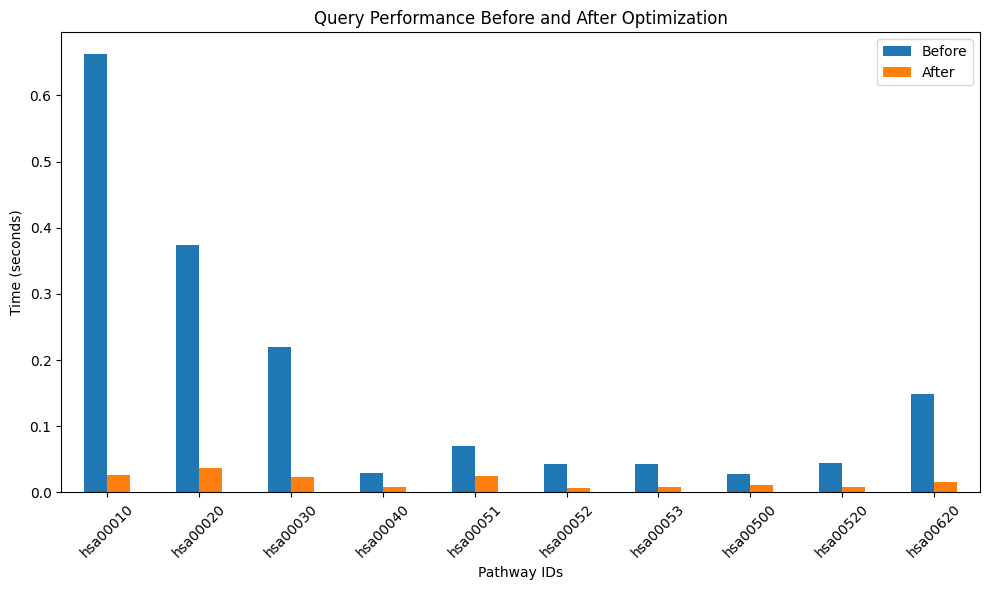

In [ ]:
timings_df = pd.DataFrame(query_timings).T


fig, ax = plt.subplots(figsize=(10, 6))
timings_df.plot(kind='bar', ax=ax)
ax.set_title('Query Performance Before and After Optimization')
ax.set_xlabel('Pathway IDs')
ax.set_ylabel('Time (seconds)')
ax.set_xticklabels(timings_df.index, rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
query_timings = {}
#pathway_ids = ['hsa00010', 'hsa00020', 'hsa00040', 'hsa00052', 'hsa00053',
#               'hsa00520', 'hsa00620', 'hsa00630', 'hsa00640', 'hsa00650']

pathway_ids = ['hsa00010', 'hsa00020', 'hsa00030', 'hsa00040', 'hsa00051',
               'hsa00052', 'hsa00053', 'hsa00500', 'hsa00520', 'hsa00620']

for pathway_id in pathway_ids:
    # Compute mean and standard deviation on-the-fly for 'Before' optimization
    start_time = time.time()
    mean_val_direct = pathway_activity_scores[pathway_id].mean()
    std_val_direct = pathway_activity_scores[pathway_id].std()
    high_threshold_direct = mean_val_direct + 2 * std_val_direct  # Detecting high outliers

    outliers_before = pathway_activity_scores[pathway_activity_scores[pathway_id] > high_threshold_direct]
    end_time = time.time()
    query_time_before_outliers = end_time - start_time

    # Use precomputed mean and std values for 'After' optimization
    mean_val = stats_index.loc['mean', pathway_id]
    std_val = stats_index.loc['std', pathway_id]
    high_threshold = mean_val + 2 * std_val  # Outliers beyond 2 standard deviations

    start_time = time.time()
    outliers_after = pathway_activity_scores[pathway_activity_scores[pathway_id] > high_threshold]
    end_time = time.time()
    query_time_after_outliers = end_time - start_time

    # Store the query times
    query_timings[pathway_id] = {'Before': query_time_before_outliers, 'After': query_time_after_outliers}


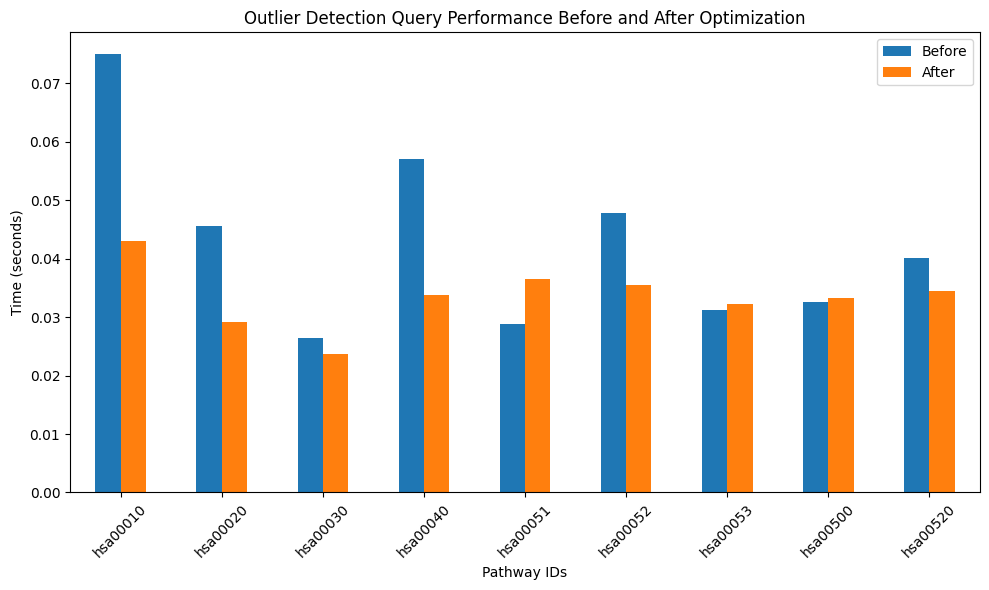

In [ ]:
import matplotlib.pyplot as plt

timings_df = pd.DataFrame(query_timings).T

fig, ax = plt.subplots(figsize=(10, 6))
timings_df[:9].plot(kind='bar', ax=ax)
ax.set_title('Outlier Detection Query Performance Before and After Optimization')
ax.set_xlabel('Pathway IDs')
ax.set_ylabel('Time (seconds)')
ax.set_xticklabels(timings_df[:9].index, rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
pip install python-igraph louvain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.8 MB/s eta 0:00:00


In [ ]:
import scanpy as sc

h5ad_path = "/content/drive/MyDrive/Colab Notebooks/E-MTAB-8221.aggregated_filtered_normalised_counts.h5ad"
adata = sc.read_h5ad(h5ad_path)

In [ ]:
import scanpy as sc
from sklearn.metrics import adjusted_rand_score

# Function to perform PCA, compute neighbors, and perform Louvain clustering
def process_adata(adata, label, resolution):
    # Perform PCA
    sc.tl.pca(adata, n_comps=10)

    # Compute the neighborhood graph
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

    # Perform Louvain clustering
    sc.tl.louvain(adata, resolution)  # Adjust the resolution parameter as needed

    # Check the clustering result
    print(f"Louvain clustering for {label}:")
    print(adata.obs['louvain'])


process_adata(adata, "Development", 1.25)


Louvain clustering for Development:
SAMEA6739629-AAACCTGAGATGTAAC     3
SAMEA6739629-AAACCTGCAATCCAAC     3
SAMEA6739629-AAACCTGCACCGAAAG    32
SAMEA6739629-AAACCTGCACGTAAGG     3
SAMEA6739629-AAACCTGCACGTCAGC    13
                                 ..
SAMEA6739639-TTTGTCAGTGCAACTT    34
SAMEA6739639-TTTGTCATCACTATTC    17
SAMEA6739639-TTTGTCATCCTTTCTC    17
SAMEA6739639-TTTGTCATCGGAATCT    23
SAMEA6739639-TTTGTCATCTTGCCGT    29
Name: louvain, Length: 139705, dtype: category
Categories (42, object): ['0', '1', '2', '3', ..., '38', '39', '40', '41']


"# Calculate Adjusted Rand Index (ARI) # if we had some true_labels' NumPy array or a pandas Series with the known cell types\nari_score = adjusted_rand_score(true_labels, predicted_labels)\nprint('Adjusted Rand Index:', ari_score)"

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg_dev = silhouette_score(adata.obsm['X_pca'][:, :10], adata.obs['louvain'])
print('The average silhouette score for development dataset is:', silhouette_avg_dev)

The average silhouette score for development dataset is: -0.08437641


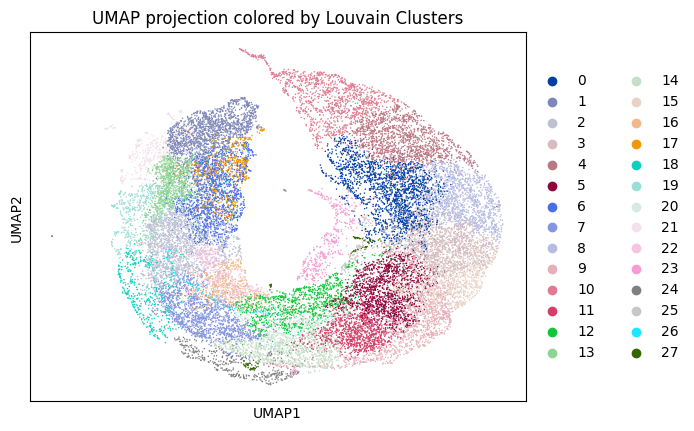

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

sc.tl.umap(adata)  # This computes the UMAP embeddings based on the neighborhood graph
sc.pl.umap(adata, color='louvain', title='UMAP projection colored by Louvain Clusters')


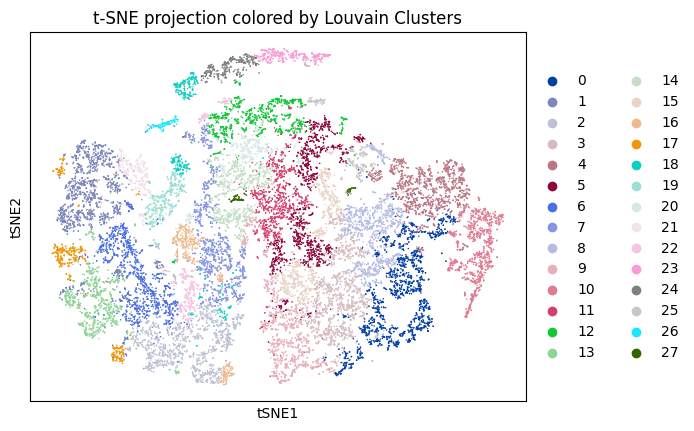

In [ ]:
sc.tl.tsne(adata, n_pcs=10)  # Use the same number of principal components as used for the neighborhood graph
sc.pl.tsne(adata, color='louvain', title='t-SNE projection colored by Louvain Clusters')

In [ ]:
# In case we want to get a specfied number of clusters, we can use this to get the corresponding resolution
import scanpy as sc
# Start with a guess for the resolution parameter
resolution = 1.25
cluster_count = 0

while True:
    # Run Louvain clustering with the current resolution
    sc.tl.louvain(adata, resolution=resolution)

    # Get the unique clusters
    unique_clusters = adata.obs['louvain'].unique()
    cluster_count = len(unique_clusters)
    print(resolution, cluster_count, number_of_clusters_dev)

    # Check if we are close to the desired number of clusters
    if cluster_count > number_of_clusters_dev:
        # Too many clusters, decrease resolution
        resolution -= 0.1
    elif cluster_count < number_of_clusters_dev:
        # Too few clusters, increase resolution
        resolution += 0.1
    else:
        # We have the desired number of clusters
        break

    # Avoid infinite loop in case we can't find the exact number
    if resolution <= 0 or resolution > 10:
        break

print(f'Resolved with {cluster_count} clusters at a resolution of {resolution}')

1.25 34 34
Resolved with 34 clusters at a resolution of 1.25
